In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

In [5]:
data = pd.read_csv('Kobe.csv')

In [6]:
data.head(5)

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [7]:
target = 'shot_made_flag'

**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge (с встроеной регуляризацией) на тех же признаках - построить сравнительную таблицу или график коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. 

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC
5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

# 1/Провести анализ данных

In [8]:
# смотрим инфо о NULL, типе данных и их описании
#NULL  есть в таргетной переменной shot_made_flag.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         30697 non-null  object 
 1   combined_shot_type  30697 non-null  object 
 2   game_event_id       30697 non-null  int64  
 3   game_id             30697 non-null  int64  
 4   lat                 30697 non-null  float64
 5   loc_x               30697 non-null  int64  
 6   loc_y               30697 non-null  int64  
 7   lon                 30697 non-null  float64
 8   minutes_remaining   30697 non-null  int64  
 9   period              30697 non-null  int64  
 10  playoffs            30697 non-null  int64  
 11  season              30697 non-null  object 
 12  seconds_remaining   30697 non-null  int64  
 13  shot_distance       30697 non-null  int64  
 14  shot_made_flag      25697 non-null  float64
 15  shot_type           30697 non-null  object 
 16  shot

In [9]:
#Создание описательной статистики.
data.describe(include=['int64'])

,game_event_id,game_id,loc_x,loc_y,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,team_id,shot_id
count,30697.000000,3.069700e+04,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,3.069700e+04,30697.000000
mean,249.190800,2.476407e+07,7.110499,91.107535,4.885624,2.519432,0.146562,28.365085,13.437437,1.610613e+09,15349.000000
std,150.003712,7.755175e+06,110.124578,87.791361,3.449897,1.153665,0.353674,17.478949,9.374189,0.000000e+00,8861.604943
min,2.000000,2.000001e+07,-250.000000,-44.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.610613e+09,1.000000
25%,110.000000,2.050008e+07,-68.000000,4.000000,2.000000,1.000000,0.000000,13.000000,5.000000,1.610613e+09,7675.000000
50%,253.000000,2.090035e+07,0.000000,74.000000,5.000000,3.000000,0.000000,28.000000,15.000000,1.610613e+09,15349.000000
75%,368.000000,2.960047e+07,95.000000,160.000000,8.000000,3.000000,0.000000,43.000000,21.000000,1.610613e+09,23023.000000
max,659.000000,4.990009e+07,248.000000,791.000000,11.000000,7.000000,1.000000,59.000000,79.000000,1.610613e+09,30697.000000


In [10]:
#Создание описательной статистики.
data.describe(include=['object', 'category'])

,action_type,combined_shot_type,season,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_name,game_date,matchup,opponent
count,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697
unique,57,6,20,2,6,7,5,1,1559,74,33
top,Jump Shot,Jump Shot,2005-06,2PT Field Goal,Center(C),Mid-Range,Less Than 8 ft.,Los Angeles Lakers,2016-04-13,LAL @ SAS,SAS
freq,18880,23485,2318,24271,13455,12625,9398,30697,50,1020,1978


In [11]:
#разделение на обучающий и тестовый наборы для некоторых визуализаций (особенно графиков подсчета)
# в тестовый записываем данные где таргетная переменная равна Null
data_test = data.loc[(data.shot_made_flag.isnull()),:]
data_test.index = range(len(data_test))

#из обучающего соответсвенно удаляем строки с NULL в таргетной переменной
data.dropna(inplace=True)
data.index =  range(len(data))

D:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='shot_made_flag', ylabel='count'>

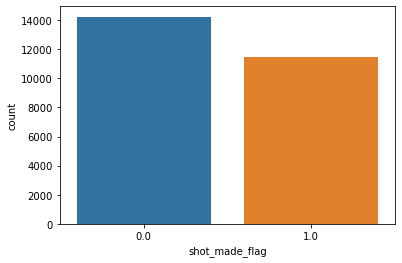

In [12]:
#Давайте визуализируем данные.
#проверка распределения классов
#Тут не большая разница. Нет необходимости выполнять балансировку классов.
sns.countplot(data.shot_made_flag)

In [13]:
# смотрим названия колонок
data.columns

Index(['action_type', 'combined_shot_type', 'game_event_id', 'game_id', 'lat',
       'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'season', 'seconds_remaining', 'shot_distance', 'shot_made_flag',
       'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range',
       'team_id', 'team_name', 'game_date', 'matchup', 'opponent', 'shot_id'],
      dtype='object')

Из приведенного выше описания следует проверить следующие фичи:

Числовые характеристики  lat, loc_x, loc_y, lon, minutes_remaining, seconds_remaining, shot_distance

Категориальные характеристики - action_type, combined_shot_type, period, playoffs, season, shot_type, shot_zone_area, shot_zone_basic, shot_zone_range

###### Давайте рассмотрим влияние фич на целевую переменную одну за другой.

##### Числовые характеристики


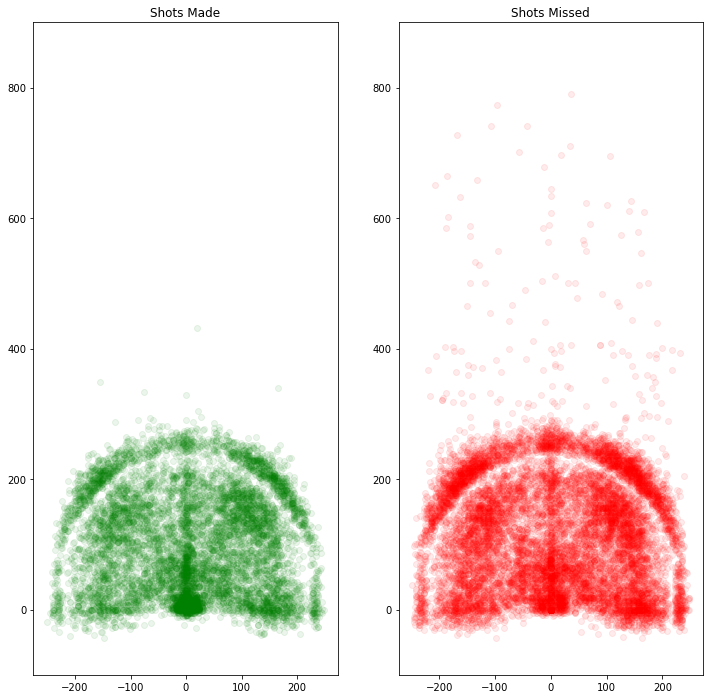

In [14]:
#loc_x and loc_y - Точки, из которых Кобе сделал удар
plt.figure(figsize=(12,12))
plt.subplot(121)
plt.scatter(data.loc[data.shot_made_flag==1, 'loc_x'], data.loc[data.shot_made_flag==1, 'loc_y'], alpha=0.08, c='g')
plt.title('Shots Made')
plt.ylim(-100, 900)
plt.subplot(122)
plt.scatter(data.loc[data.shot_made_flag==0, 'loc_x'], data.loc[data.shot_made_flag==0, 'loc_y'], alpha=0.08, c='r')
plt.title('Shots Missed')
plt.ylim(-100, 900)
plt.show()

Очевидно, что расстояние имеет значение, из-за дальней корзины много промахов. В соответствии с интуицией, удары, которые он делает из-за корзины, имеют более высокий шанс успеха. Также количество промахов больше из области внешнего кольца. Но есть странная вещь, у обоих много бросков с 0,0. Давайте проверим количество для лучшего понимания

In [15]:
c= data.loc[(data.loc_x==0) & (data.loc_y==0)]

c.shot_made_flag.value_counts()

1.0    2696
0.0    1625
Name: shot_made_flag, dtype: int64

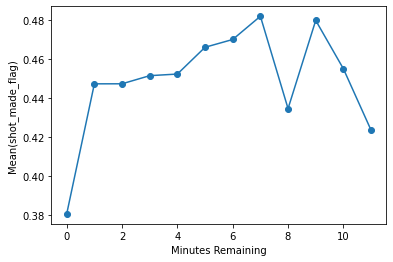

D:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='minutes_remaining', ylabel='count'>

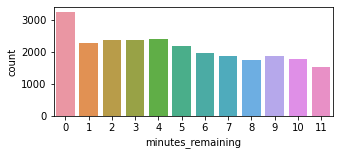

In [16]:
#Minutes Remaining
c = data.groupby('minutes_remaining')['shot_made_flag'].mean()
plt.plot(c.index, c.values)
plt.xlabel('Minutes Remaining')
plt.ylabel('Mean(shot_made_flag)')
plt.scatter(c.index, c.values)
plt.show()
# Здесь не так много шаблонов. Кроме 0 мин. В последнюю минуту произошло резкое падение количества выстрелов.
plt.figure(figsize=(5,2))
sns.countplot(data.minutes_remaining)
#Много попыток делается в последнюю секунду.

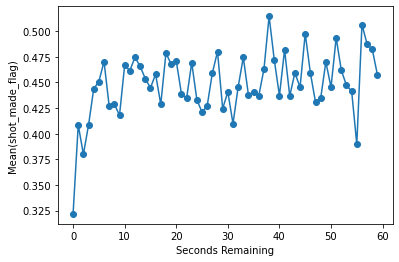

D:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='seconds_remaining', ylabel='count'>

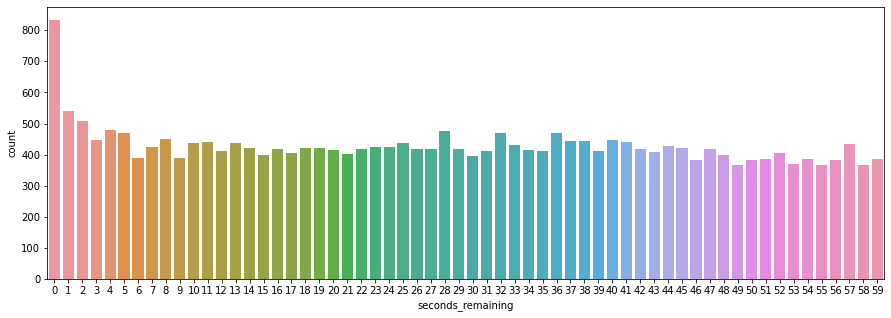

In [17]:
#Seconds remaining
c = data.groupby('seconds_remaining')['shot_made_flag'].mean()
plt.plot(c.index, c.values)
plt.xlabel('Seconds Remaining')
plt.ylabel('Mean(shot_made_flag)')
plt.scatter(c.index, c.values)
plt.show()
#Интересно отметить, что его производительность резко снижается в последние 3 секунды игры, как это было видно по минутам.
plt.figure(figsize=(15,5))
sns.countplot(data.seconds_remaining)
# Много попыток делается в последнюю секунду.

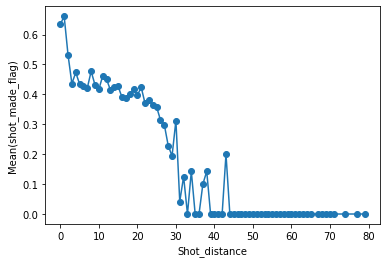

In [18]:
#Shot Distance
c = data.groupby('shot_distance')['shot_made_flag'].mean()
plt.plot(c.index, c.values)
plt.xlabel('Shot_distance')
plt.ylabel('Mean(shot_made_flag)')
plt.scatter(c.index, c.values)
plt.show()
#Очень интуитивно понятно. С увеличением расстояния точность снижается. Важный признак для предсказания

##### Категориальные характеристики

In [19]:
#Давайте исследуем территорию арены.
#Shot_zone_area, shot_zone_basic, shot_zone_range with loc_x and loc_y  и увидеть среднее количество сделанных ударов.

#Просто генератор случайных цветов, буду использовать для визуализации
def color_generator(num_colors):
    colors = []
    for i in range(num_colors):
        colors.append((np.random.rand(), np.random.rand(), np.random.rand()))
    return colors

colors = color_generator(100)

In [20]:
#для построения точек zone_wise и проверки их среднего значения целевой переменной
def plot_zone_wise(zone_name):
    c_mean = data.groupby(zone_name)['shot_made_flag'].mean()
    plt.figure(figsize=(15,15))
    for i, area in enumerate(data[zone_name].unique()):
        plt.subplot(121)
        c = data.loc[(data[zone_name]==area)]
        plt.scatter(c.loc_x, c.loc_y,alpha=0.5 ,c=colors[i])
        plt.text(c.loc_x.mean(), c.loc_y.quantile(0.80), '%0.3f'%(c_mean[area]),size=15, bbox=dict(facecolor='red', alpha=0.5))
        plt.ylim(-100, 900)
    plt.legend(data[zone_name].unique())
    plt.title(zone_name)
    plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

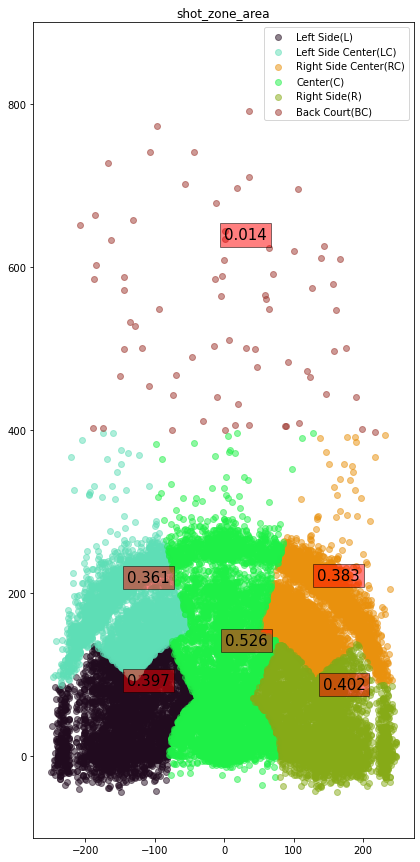

In [21]:
#Значения в красной рамке показывают среднее значение переменной shot_made_flag в этой конкретной зоне.
plot_zone_wise('shot_zone_area')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

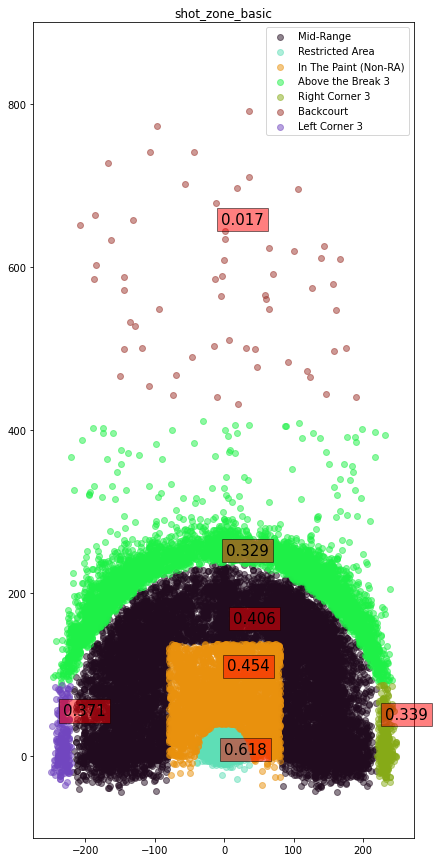

In [22]:
plot_zone_wise('shot_zone_basic')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

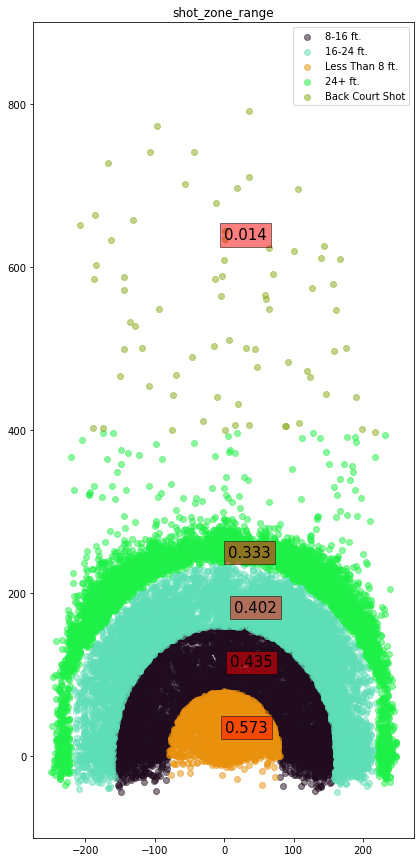

In [23]:
plot_zone_wise('shot_zone_range')

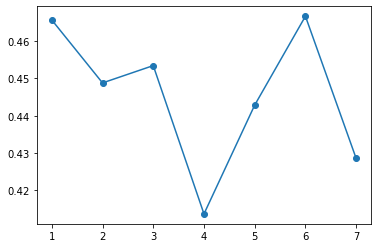

In [24]:
#Period
c = data.groupby('period')['shot_made_flag'].mean()
plt.plot(c.index, c.values)
plt.scatter(c.index, c.values)
plt.show()
# Много вариаций. Может оказаться важной особенностью.

D:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='playoffs', ylabel='shot_made_flag'>

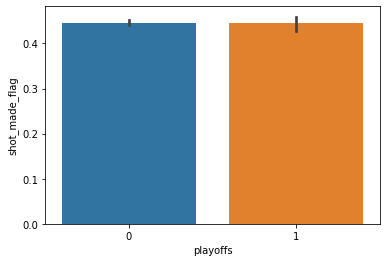

In [25]:
#Playoffs
sns.barplot('playoffs', 'shot_made_flag', data=data)


D:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='playoffs', ylabel='count'>

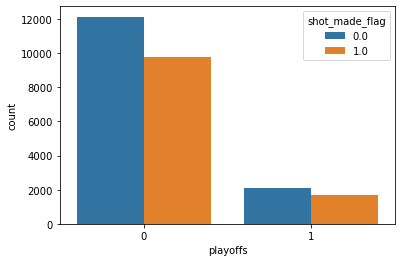

In [26]:
sns.countplot('playoffs', hue ='shot_made_flag', data=data)
#Всего две категории с почти нулевым влиянием на целевую переменную.

D:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


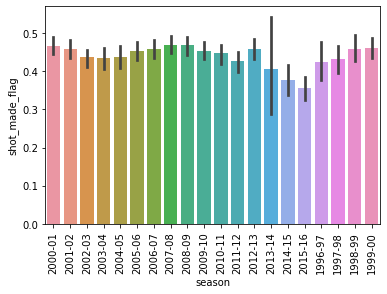

In [27]:
#Season
sns.barplot('season', 'shot_made_flag', data=data)
plt.xticks(rotation='vertical')
plt.show()
#Его производительность почти стабильна, за исключением нескольких сезонов.

D:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='shot_type', ylabel='shot_made_flag'>

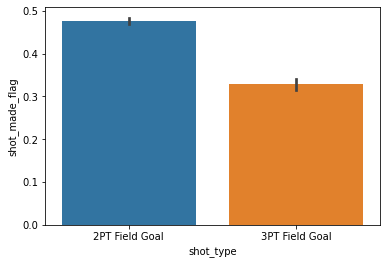

In [28]:
#Shot_type
sns.barplot(data.shot_type, data.shot_made_flag)

D:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='combined_shot_type', ylabel='shot_made_flag'>

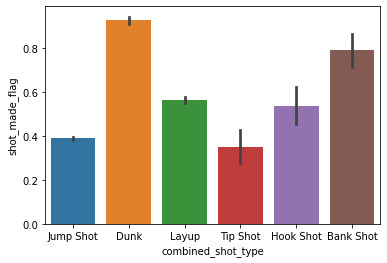

In [29]:
#Combined_shot_type
sns.barplot(data.combined_shot_type, data.shot_made_flag)
# Кcombined_shot_type оказывает огромное влияние на успех выстрела. 
#У Dunk самый высокий показатель успеха, за которым следует Bank Shot.

D:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


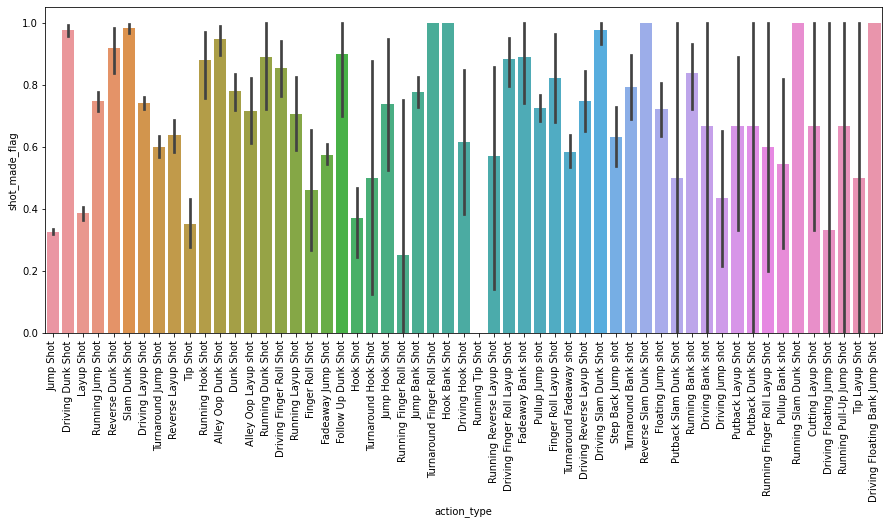

In [30]:
#Action Type
plt.figure(figsize=(15,6))
sns.barplot('action_type', 'shot_made_flag', data=data)
plt.xticks(rotation='vertical')
plt.show()

#Таковы Action Type. И они оказывают огромное влияние на точность, как мы видим. 
#Также есть специализации в каждом ударе. И каждое добавленное действие могло как-то повлиять на успех удара. 
#Так что считать каждое действие разным может быть полезно.

In [36]:
#Удаляем строки с пустым целевым атрибутом:
data = data.dropna(subset=['shot_made_flag']).reset_index()

In [37]:
#Преобразуем в нормальное время:
data['dt_game_date'] = pd.to_datetime(data['game_date'])

In [43]:
#Добавим переменных
data['secondsFromPeriodEnd']   = 60*data['minutes_remaining']+data['seconds_remaining']
data['secondsFromPeriodStart'] = 60*(11-data['minutes_remaining'])+(60-data['seconds_remaining'])
data['secondsFromGameStart']   = (data['period'] <= 4).astype(int)*(data['period']-1)*12*60 + (data['period'] > 4).astype(int)*((data['period']-4)*5*60 + 3*12*60) + data['secondsFromPeriodStart']


In [44]:
def split_train_test(data, test_ratio):
    test_count = round(len(data) * test_ratio)
    train_count = len(data) - test_count
    return data.sort_values(by=['dt_game_date', 'secondsFromGameStart'], ascending=False).tail(train_count).reset_index(), \
           data.sort_values(by=['dt_game_date', 'secondsFromGameStart'], ascending=False).head(test_count).reset_index()
           

In [45]:
train_data, test_data = split_train_test(data, 0.2)
len(train_data), len(test_data)

(20558, 5139)

### Опредляем, с какими фичами будем работать

In [46]:
#Разделяем признаки на числовые и категориальные, оставляем только явно полезные для нас признаки
num_columns = ['loc_x', 'loc_y', 'minutes_remaining', 'period', 'playoffs', 'seconds_remaining', 'shot_distance',
               'secondsFromPeriodEnd', 'secondsFromPeriodStart', 'secondsFromGameStart']
cat_columns = ['action_type', 'combined_shot_type', 'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range',
               'opponent']

Так как мы разделили выборку по времни, части могут быть не сбалансированы, поэтому категориальные переменные будем изучать на общем наборе данных

Получим список значений для всех категорий, для OneHotEncoder-а

In [47]:
def get_cat_categories(df, cat_columns):
    categories = []
    for column in cat_columns:
        categories.append(list(df[column].unique()))    
    return categories

In [48]:

categories = get_cat_categories(data, cat_columns)

In [52]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(categories=categories), cat_columns),
        ('num', StandardScaler(), num_columns)
    ],
    sparse_threshold=0,
    remainder='drop'
)

In [53]:
def get_feature_names(column_transformer, df):
    feature_names = []
    for _, tr, columns in column_transformer.transformers:
        if type(tr).__name__ == 'OneHotEncoder':
            tr.fit(df[columns]) # wtf?? удивительно, но факт, но ColumnTransformer сначала клонирует незафиченный трансформер, а потом его выполняет
            feature_names.extend(list(tr.get_feature_names(columns)))
        elif type(tr).__name__ == 'StandardScaler':
            feature_names.extend(columns)
        else:
            raise RuntimeError(f'Unknown class: {type(tr).__name__}, plrase update function')
    return feature_names

In [54]:
feature_names = get_feature_names(preprocessor, train_data)

In [55]:
len(feature_names)

124

Пробуем LinearRegression

In [56]:
X = preprocessor.fit_transform(data)
y = np.array(data['shot_made_flag'])

In [58]:
from sklearn.linear_model import LinearRegression
clf_lin = LinearRegression()

In [59]:
clf_lin.fit(X, y)

LinearRegression()

In [60]:

y_pred_lin = clf_lin.predict(X)

In [62]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(y, y_pred_lin)
lin_rmse = np.sqrt(lin_mse)

In [63]:
print(f'RMSE: {lin_rmse}')
print(f'Intercept: {clf_lin.intercept_}')
print(f'R^2: {clf_lin.score(X, y)}')
print(f'RSS: {sum((y_pred_lin - y) ** 2)}')

RMSE: 0.4584110106772778
Intercept: -2915913784390.601
R^2: 0.14957712028822134
RSS: 5399.984404087067


Пробуем Lasso. 

In [65]:
from sklearn.linear_model import Lasso 
clf_lasso = Lasso()
clf_lasso.fit(X, y)

Lasso()

In [66]:
y_pred_lasso = clf_lasso.predict(X)
lasso_mse = mean_squared_error(y, y_pred_lasso)
lasso_rmse = np.sqrt(lasso_mse)

In [67]:
print(f'RMSE: {lasso_rmse}')
print(f'Intercept: {clf_lasso.intercept_}')
print(f'R^2: {clf_lasso.score(X, y)}')
print(f'RSS: {sum((y_pred_lasso - y) ** 2)}')

RMSE: 0.49709291421222224
Intercept: 0.44616103047048294
R^2: 0.0
RSS: 6349.763785655984


Теперь Ridge

In [69]:
from sklearn.linear_model import Ridge 
clf_ridge = Ridge()
clf_ridge.fit(X, y)

Ridge()

In [70]:
y_pred_ridge = clf_ridge.predict(X)
ridge_mse = mean_squared_error(y, y_pred_ridge)
ridge_rmse = np.sqrt(ridge_mse)

In [71]:
print(f'RMSE: {ridge_rmse}')
print(f'Intercept: {clf_ridge.intercept_}')
print(f'R^2: {clf_ridge.score(X, y)}')
print(f'RSS: {sum((y_pred_ridge - y) ** 2)}')

RMSE: 0.4582593160605802
Intercept: 0.623739660285352
R^2: 0.15013986082043174
RSS: 5396.411134634902


In [72]:
df_coef = pd.DataFrame()
df_coef['Features'] = pd.Series(feature_names)
df_coef['LinearRegression'] = clf_lin.coef_
df_coef['Lasso'] = clf_lasso.coef_
df_coef['Ridge'] = clf_ridge.coef_

In [73]:
pd.option_context('display.max_rows', None, 'display.max_columns', None)  # more options can be specified also
df_coef

,Features,LinearRegression,Lasso,Ridge
0,action_type_Jump Shot,-8.365982e+10,-0.0,-0.341644
1,action_type_Driving Dunk Shot,-5.656214e+11,0.0,0.105976
2,action_type_Layup Shot,7.104026e+11,-0.0,-0.281306
3,action_type_Running Jump Shot,-8.365982e+10,0.0,0.105347
4,action_type_Reverse Dunk Shot,-5.656214e+11,0.0,0.044793
...,...,...,...,...
119,seconds_remaining,8.121681e+10,0.0,0.011746
120,shot_distance,1.452637e-02,-0.0,0.014057
121,secondsFromPeriodEnd,-4.827365e+11,0.0,0.000823
122,secondsFromPeriodStart,4.827365e+11,-0.0,-0.000823


### Попробуем обучить модели на части данных и проверить на тесте.

In [83]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [75]:
X_train = preprocessor.fit_transform(train_data)
y_train = np.array(train_data['shot_made_flag'])

In [77]:
X_test = preprocessor.fit_transform(test_data)
y_test = np.array(test_data['shot_made_flag'])

LinearRegression

In [80]:
clf_lin_test = LinearRegression()
clf_lin_test.fit(X_train, y_train)
y_pred_lin_test = clf_lin.predict(X_test)
y_pred_lin_train = clf_lin.predict(X_train)
lin_mse_test = mean_squared_error(y_test, y_pred_lin_test)
lin_rmse_test = np.sqrt(lin_mse_test)
lin_roc_auc_test = roc_auc_score(y_test, y_pred_lin_test)
lin_roc_auc_train = roc_auc_score(y_train, y_pred_lin_train)

In [81]:
print(f'RMSE: {lin_rmse_test}')
print(f'Intercept: {clf_lin_test.intercept_}')
print(f'R^2: {clf_lin_test.score(X_test, y_test)}')
print(f'RSS: {sum((y_pred_lin_test - y_test) ** 2)}')
print(f'ROC AUC test: {lin_roc_auc_test}')
print(f'ROC AUC train: {lin_roc_auc_train}')

RMSE: 4263157831.843886
Intercept: 3199832003879.152
R^2: -4.90045917293608e+21
RSS: 9.339883103925e+22
ROC AUC test: 0.4835027475308036
ROC AUC train: 0.5203067821699369


In [84]:
lin_fpr_train, lin_tpr_train, _ = roc_curve(y_train, y_pred_lin_train)
lin_fpr_test, lin_tpr_test, _ = roc_curve(y_test, y_pred_lin_test)

In [85]:
def plt_roc_auc(title, fpr_train, tpr_train, roc_auc_train, fpr_test, tpr_test, roc_auc_test):
    plt.figure(figsize=(8, 8))
    plt.plot(fpr_train, tpr_train, label=f'Train ROC AUC {roc_auc_train}')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC AUC {roc_auc_test}')
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()    

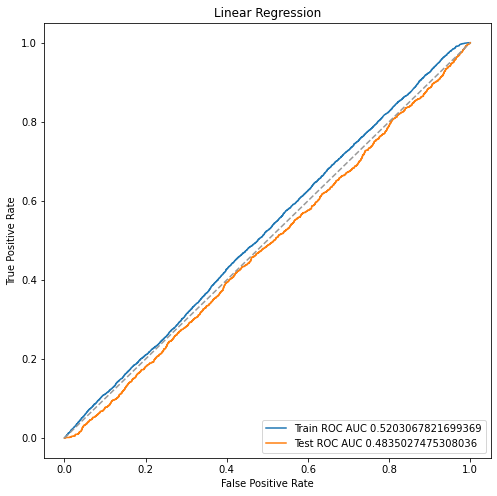

In [86]:

plt_roc_auc('Linear Regression', lin_fpr_train, lin_tpr_train, lin_roc_auc_train, lin_fpr_test, lin_tpr_test, lin_roc_auc_test)

Lasso

In [87]:
clf_lasso_test = Lasso()
clf_lasso_test.fit(X_train, y_train)
y_pred_lasso_train = clf_lasso_test.predict(X_train)
y_pred_lasso_test = clf_lasso_test.predict(X_test)
lasso_mse_test = mean_squared_error(y_test, y_pred_lasso_test)
lasso_rmse_test = np.sqrt(lasso_mse_test)
lasso_roc_auc_train = roc_auc_score(y_test, y_pred_lasso_test)
lasso_roc_auc_test = roc_auc_score(y_test, y_pred_lasso_test)

In [88]:
print(f'RMSE: {lasso_rmse_test}')
print(f'Intercept: {clf_lasso_test.intercept_}')
print(f'R^2: {clf_lasso_test.score(X_test, y_test)}')
print(f'RSS: {sum((y_pred_lasso_test - y_test) ** 2)}')
print(f'ROC AUC train: {lasso_roc_auc_train}')
print(f'ROC AUC test: {lasso_roc_auc_test}')

RMSE: 0.4944384817099362
Intercept: 0.4533514933359276
R^2: -0.00531617724269462
RSS: 1256.3283092732638
ROC AUC train: 0.5
ROC AUC test: 0.5


In [89]:
lasso_fpr_train, lasso_tpr_train, _ = roc_curve(y_train, y_pred_lasso_train)
lasso_fpr_test, lasso_tpr_test, _ = roc_curve(y_test, y_pred_lasso_test)

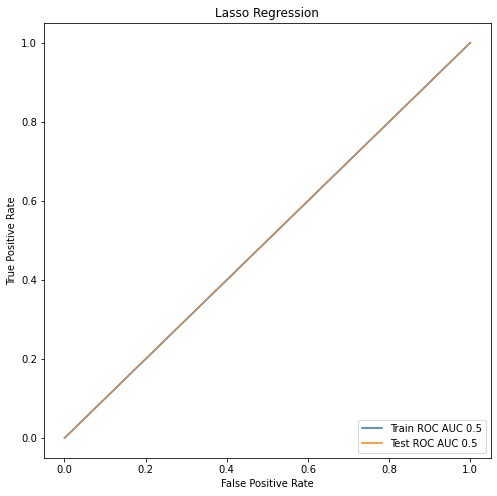

In [90]:
plt_roc_auc('Lasso Regression', lasso_fpr_train, lasso_tpr_train, lasso_roc_auc_train, lasso_fpr_test, lasso_tpr_test, lasso_roc_auc_test)


Ridge

In [91]:

clf_ridge_test = Ridge()
clf_ridge_test.fit(X_train, y_train)
y_pred_ridge_train = clf_ridge_test.predict(X_train)
y_pred_ridge_test = clf_ridge_test.predict(X_test)
ridge_mse_test = mean_squared_error(y_test, y_pred_ridge_test)
ridge_rmse_test = np.sqrt(ridge_mse_test)
ridge_roc_auc_train = roc_auc_score(y_train, y_pred_ridge_train)
ridge_roc_auc_test = roc_auc_score(y_test, y_pred_ridge_test)

In [92]:

print(f'RMSE: {ridge_rmse_test}')
print(f'Intercept: {clf_ridge_test.intercept_}')
print(f'R^2: {clf_ridge_test.score(X_test, y_test)}')
print(f'RSS: {sum((y_pred_ridge_test - y_test) ** 2)}')
print(f'ROC AUC train: {ridge_roc_auc_train}')
print(f'ROC AUC test: {ridge_roc_auc_test}')

RMSE: 0.46966379220534016
Intercept: 0.64055348598408
R^2: 0.09290598046161813
RSS: 1133.581575345013
ROC AUC train: 0.7049089128546845
ROC AUC test: 0.6799659925912431


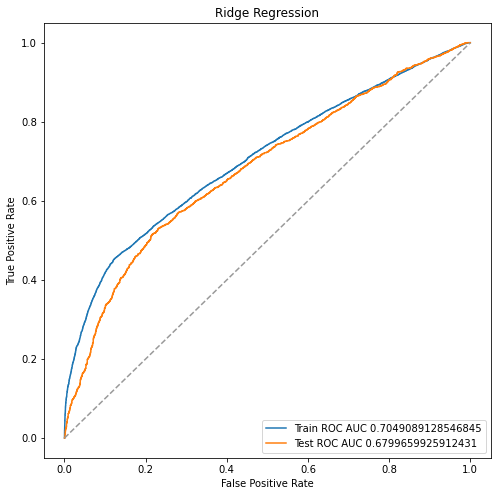

In [93]:
ridge_fpr_train, ridge_tpr_train, _ = roc_curve(y_train, y_pred_ridge_train)
ridge_fpr_test, ridge_tpr_test, _ = roc_curve(y_test, y_pred_ridge_test)
plt_roc_auc('Ridge Regression', ridge_fpr_train, ridge_tpr_train, ridge_roc_auc_train, ridge_fpr_test, ridge_tpr_test, ridge_roc_auc_test)

### PCA

In [95]:
from sklearn.decomposition import PCA 
pca = PCA(n_components=len(feature_names))
pca.fit(X)

PCA(n_components=124)

In [100]:
for i in range(1, 21):
    print(f'components: {i}, explained variance ratio: {sum(pca.explained_variance_ratio_[:i])}')

components: 1, explained variance ratio: 0.2270628388735406
components: 2, explained variance ratio: 0.41236702913152357
components: 3, explained variance ratio: 0.5391960907166211
components: 4, explained variance ratio: 0.6173954231331513
components: 5, explained variance ratio: 0.6870422663885003
components: 6, explained variance ratio: 0.7554961012974564
components: 7, explained variance ratio: 0.812580498180225
components: 8, explained variance ratio: 0.8392460120361399
components: 9, explained variance ratio: 0.860998348976989
components: 10, explained variance ratio: 0.8726974482818609
components: 11, explained variance ratio: 0.8823281352231215
components: 12, explained variance ratio: 0.8901482715088264
components: 13, explained variance ratio: 0.8964750631805801
components: 14, explained variance ratio: 0.9023579067615674
components: 15, explained variance ratio: 0.9073141673259186
components: 16, explained variance ratio: 0.911600979270023
components: 17, explained variance 